# Brain Tumor Detection - Data Preprocessing

## Import necessary libraries

In [62]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, LSTM, ConvLSTM2D, Lambda, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler, CSVLogger
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold

import keras_tuner as kt

from math import floor

from config import *

## 1. Understanding the data
The dataset contains images of human brain MRI images which are classified into 4 classes: **glioma**, **meningioma**, **no tumor** and **pituitary**.

In [2]:
glioma_images = os.listdir(DATASET_FOLDER + "/glioma")
meningioma_images = os.listdir(DATASET_FOLDER + "/meningioma")
no_tumor_images = os.listdir(DATASET_FOLDER + "/notumor")
pituitary_images = os.listdir(DATASET_FOLDER + "/pituitary")


### Get number of images

In [3]:
print(len(glioma_images), len(meningioma_images), len(no_tumor_images), len(pituitary_images))
NUM_IMAGES = len(glioma_images) + len(meningioma_images) + len(no_tumor_images) + len(pituitary_images)
print(NUM_IMAGES)

120 120 120 120
480


*As there are equal number of samples for each class, there is no class imbalance and class weight is not needed*

### Visualise sample data and sizes

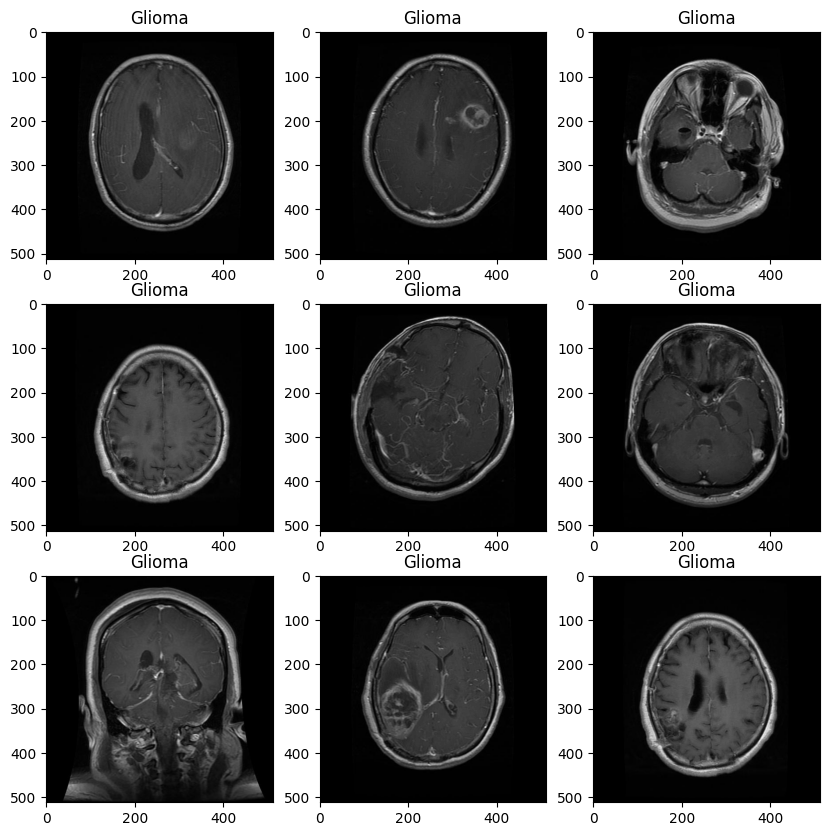

In [4]:
# Glioma
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(DATASET_FOLDER + "/glioma",glioma_images[i])),cmap='gray')
    plt.title("Glioma")
plt.show()

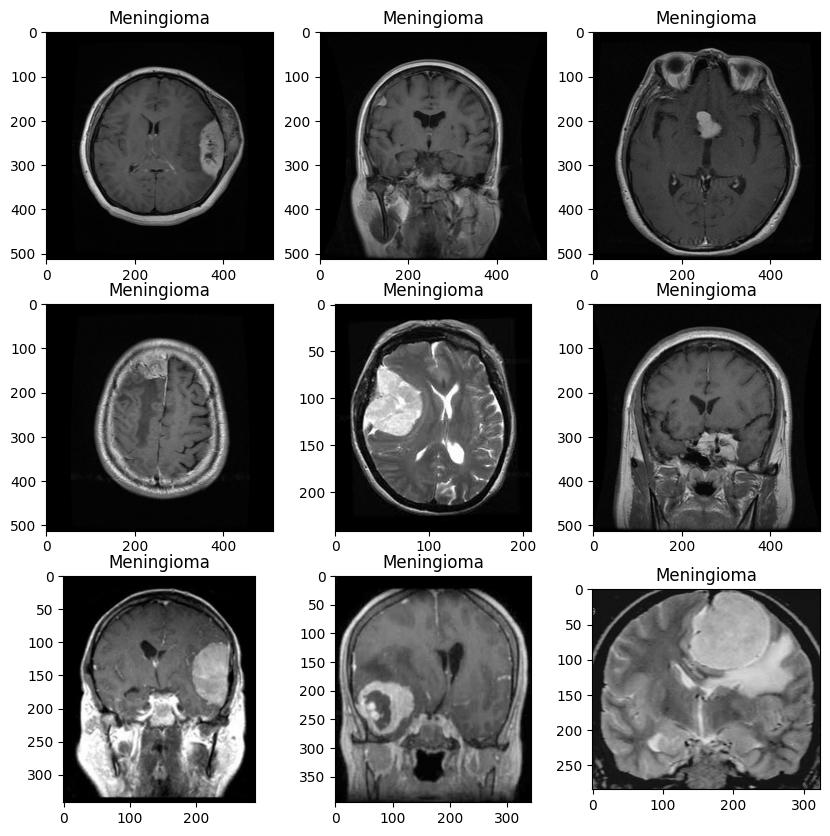

In [5]:
# Meningioma
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(DATASET_FOLDER + "/meningioma",meningioma_images[i])),cmap='gray')
    plt.title("Meningioma")
plt.show()

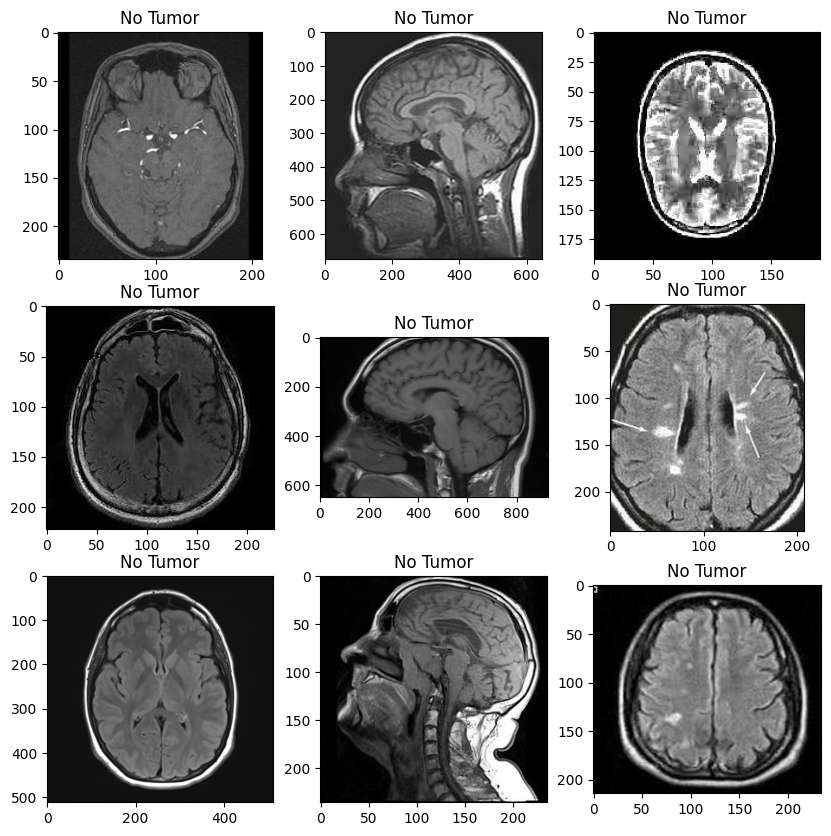

In [6]:
# No tumor
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(DATASET_FOLDER + "/notumor",no_tumor_images[i])),cmap='gray')
    plt.title("No Tumor")
plt.show()

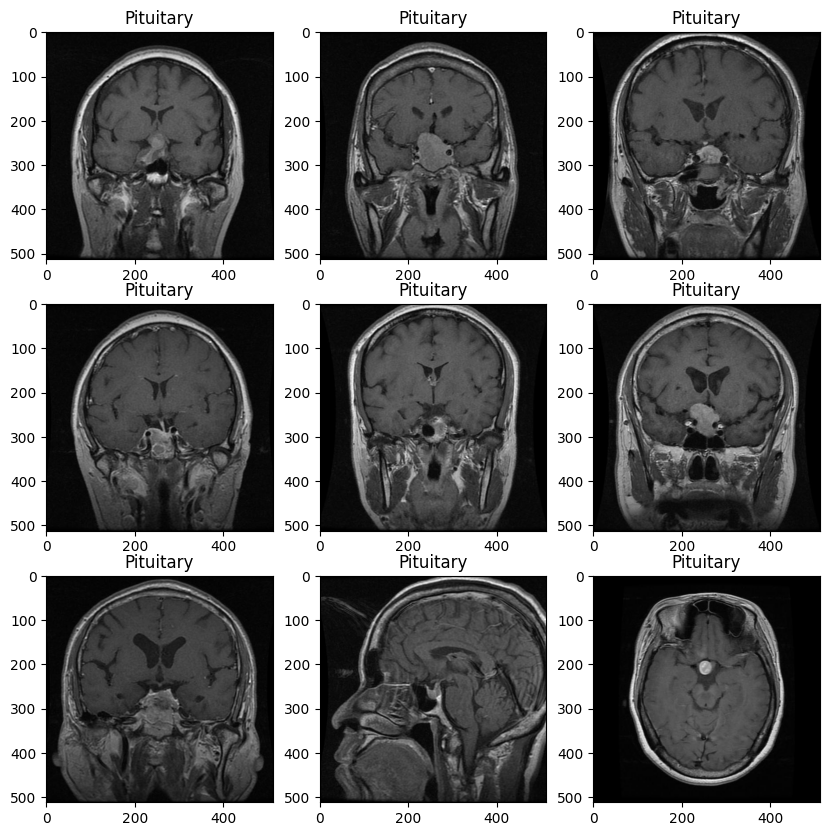

In [7]:
# Pituitary
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(DATASET_FOLDER + "/pituitary",pituitary_images[i])),cmap='gray')
    plt.title("Pituitary")
plt.show()

*Since there are differing sizes between the images, it is important to scale the images to a common size*



# 2. Data preparation
*After inspection of data, data is firstly split into train test folders with a predefined ratio of `0.3`*

In [8]:
import os
import shutil
import random

# Create train and test directories within each class label folder
for label_folder in os.listdir(DATASET_FOLDER):
    if os.path.isdir(os.path.join(DATASET_FOLDER, label_folder)):
        shutil.rmtree(os.path.join(TRAIN_FOLDER, label_folder), ignore_errors=True)
        shutil.rmtree(os.path.join(TEST_FOLDER, label_folder), ignore_errors=True)
        os.makedirs(os.path.join(TRAIN_FOLDER, label_folder), exist_ok=True)
        os.makedirs(os.path.join(TEST_FOLDER, label_folder), exist_ok=True)

        # Get list of images in the current label folder
        images = os.listdir(os.path.join(DATASET_FOLDER, label_folder))
        print(f"Found {len(images)} images in {label_folder} folder.")

        # Copy all images to train folder
        for image in images:
            shutil.copy(
                os.path.join(DATASET_FOLDER, label_folder, image),
                os.path.join(TRAIN_FOLDER, label_folder, image)
            )
        
        print(f"Copied {len(images)} images to train folder.")

        # Calculate number of images to move to test folder
        num_train_images = len(images)
        num_test_images = int(num_train_images * TEST_SIZE)
        print(f"Moving {num_test_images} images to test folder.")

        # Randomly select images for the test set
        test_images = random.sample(images, num_test_images)

        # Move the selected test images to the test folder
        for image in test_images:
            shutil.move(
                os.path.join(TRAIN_FOLDER, label_folder, image),
                os.path.join(TEST_FOLDER, label_folder, image)
            )
        print(f"Moved {num_test_images} images to test folder.\n")
        
print("Dataset splitting completed successfully.")


Found 120 images in pituitary folder.
Copied 120 images to train folder.
Moving 36 images to test folder.
Moved 36 images to test folder.

Found 120 images in notumor folder.
Copied 120 images to train folder.
Moving 36 images to test folder.
Moved 36 images to test folder.

Found 120 images in glioma folder.
Copied 120 images to train folder.
Moving 36 images to test folder.
Moved 36 images to test folder.

Found 120 images in meningioma folder.
Copied 120 images to train folder.
Moving 36 images to test folder.
Moved 36 images to test folder.

Dataset splitting completed successfully.


### Data augmentation
> Previously, it was observed that rescaling was necessary. As a result, the training dataset is resized using `flow_from_directory` and augmented using `ImageDataGenerator`, which generates a flow for generalization.

In [65]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_dataset = train_datagen.flow_from_directory(TRAIN_FOLDER,
                                                 target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

test_dataset = test_datagen.flow_from_directory(TEST_FOLDER,
                                                 target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)


Found 336 images belonging to 4 classes.
Found 144 images belonging to 4 classes.


In [66]:
train_dataset.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [67]:
test_dataset.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

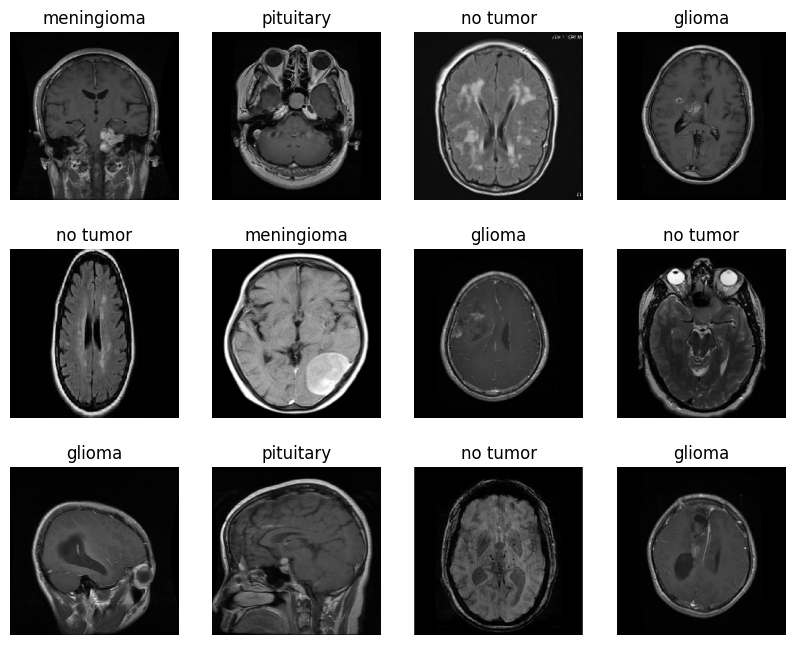

In [53]:
labels = ['glioma', 'meningioma', 'no tumor', 'pituitary']

sample_data = test_dataset.__getitem__(1)[0] 
sample_label = test_dataset.__getitem__(1)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

# 3. Modelling
Data is ready for training and testing
The model utilizes a pre-trained `VGG19` model with ImageNet weights as a feature extractor. A Long Short-Term Memory (LSTM) layer is then attached, followed by two fully connected layers. Finally, the model produces a softmax output with four units for classification.
The following hyperparameters are finetuned:
1. Activation function choice for `LSTM` layer - `lstm_activation`: `relu`, `tanh`
2. Activation function choice for first fully connected layer -  `fc1_activation`: `relu`, `tanh`
2. Activation function choice for second fully connected layer - `fc2_activation` : `relu`, `tanh`
3. Number of units in first fully connected layer - `fc1_units`: 64 to 512, step of 64
4. Number of units in second fully connected layer - `fc2_units`: 64 to 512, step of 64
5. Whether to drop out or not - `use_dropout`: `yes`, `no`
6. Dropout rate - `dropout_rate`: 0.1 to 0.5, step of 0.1
7. Learning rate - `lr`: 1e-4 to 1e-2, log sampling

In [23]:
def build_model(hp):
	# Input layer
	input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

	# Base VGG19 model as a feature extractor
	base_model = VGG19(weights="imagenet", include_top=False, input_tensor=input_layer)

	# Freeze the base model
	for layer in base_model.layers:
			layer.trainable = False

	x = base_model.output
	
	# LSTM layer
	x = Reshape((49, 512))(x)
	x = LSTM(512, activation=hp.Choice("lstm_activation", ["relu", "tanh"]), return_sequences=True, trainable=False)(x)
	x = BatchNormalization()(x)

	# FC layer
	x = Flatten(name="flatten")(x)

	# FC1 layer
	x = Dense(units=hp.Int("fc1_units", min_value=64, max_value=512, step=64), activation=hp.Choice("fc1_activation", ["relu", "tanh"]))(x)
	x = BatchNormalization()(x)

	# FC2 layer
	x = Dense(units=hp.Int("fc2_units", min_value=64, max_value=512, step=64), activation=hp.Choice("fc2_activation", ["relu", "tanh"]))(x)
	x = BatchNormalization()(x)
	
	# Dropout layer
	if hp.Choice("use_dropout", ["Yes", "No"]) == "Yes":
		x = Dropout(rate=hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1))(x)
  
	# Output layer
	output = Dense(units=4, activation='softmax')(x)

	model = Model(inputs=input_layer, outputs=output)

	model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")), metrics=["accuracy"])

	return model

# Test if the model builds successfully
build_model(kt.HyperParameters())

<Functional name=functional_3, built=True>

In [45]:
decay_rate = 0.95
decay_step = 1
INIT_LR = 1e-3

checkpoint = ModelCheckpoint(filepath='best_model_new.weights.h5', 
                        			monitor='val_accuracy',
                           		mode='max',
                             	verbose=1,
                             	save_best_only=True,
                              save_weights_only=True
														),

## Initialise tuner
Here we initialise the `keras-tuner` which will search for the optimal hyperparameters to use for model training

In [37]:
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=50,
    				 				 directory="hyperparameter-search",
    				 				 project_name="brain-tumor-classification",
)


tuner.search(train_dataset, epochs=50, validation_data=test_dataset)

Trial 90 Complete [00h 11m 32s]
val_accuracy: 0.6736111044883728

Best val_accuracy So Far: 0.8680555820465088
Total elapsed time: 08h 01m 21s


In [50]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"LSTM Activation: {best_hps.get('lstm_activation')}")
print(f"FC1 Units: {best_hps.get('fc1_units')}")
print(f"FC1 Activation: {best_hps.get('fc1_activation')}")
print(f"FC2 Units: {best_hps.get('fc2_units')}")
print(f"FC2 Activation: {best_hps.get('fc2_activation')}")
print(f"Use Dropout: {best_hps.get('use_dropout')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('lr')}")

Best Hyperparameters:
LSTM Activation: tanh
FC1 Units: 64
FC1 Activation: tanh
FC2 Units: 256
FC2 Activation: relu
Use Dropout: No
Dropout Rate: 0.5
Learning Rate: 0.00022762343549467492


In [57]:
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(train_dataset, 
               epochs=100, 
               validation_data=test_dataset, 
               callbacks=[checkpoint]
            )

Epoch 1/90
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4038 - loss: 1.5301
Epoch 1: val_accuracy did not improve from 0.76389
11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.4126 - loss: 1.5081 - val_accuracy: 0.2431 - val_loss: 1.4044 - learning_rate: 0.0010
Epoch 2/90
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5480 - loss: 1.1318
Epoch 2: val_accuracy did not improve from 0.76389
11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.5504 - loss: 1.1297 - val_accuracy: 0.2917 - val_loss: 1.3481 - learning_rate: 9.5000e-04
Epoch 3/90
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6258 - loss: 0.9109
Epoch 3: val_accuracy did not improve from 0.76389
11/11 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.6260 - loss: 0.9103 - val_accuracy: 0.3264 - val_loss: 1.3666 - learning_rate: 9.0250e-04
Epoch 4/90
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5799 - loss: 0.9643
Epoch 4: val_accuracy did not improve from 0.76389
11/11 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step 

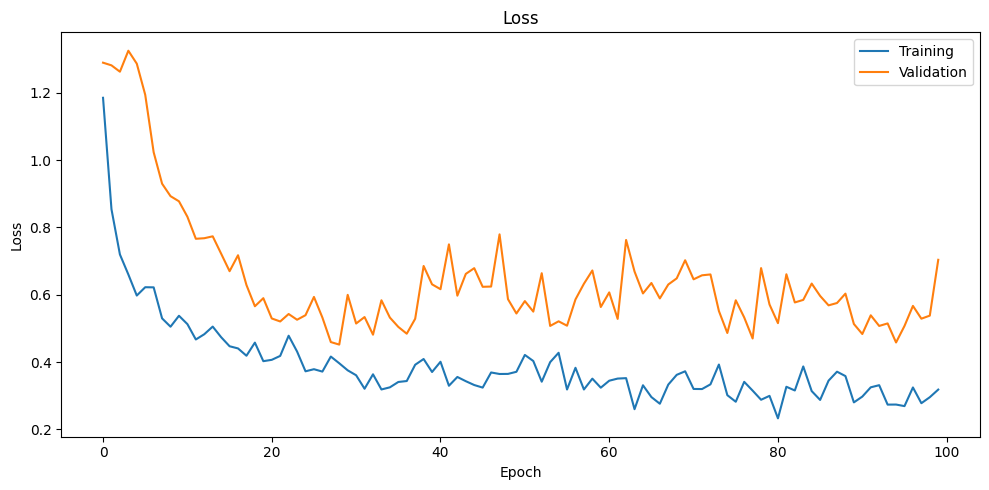

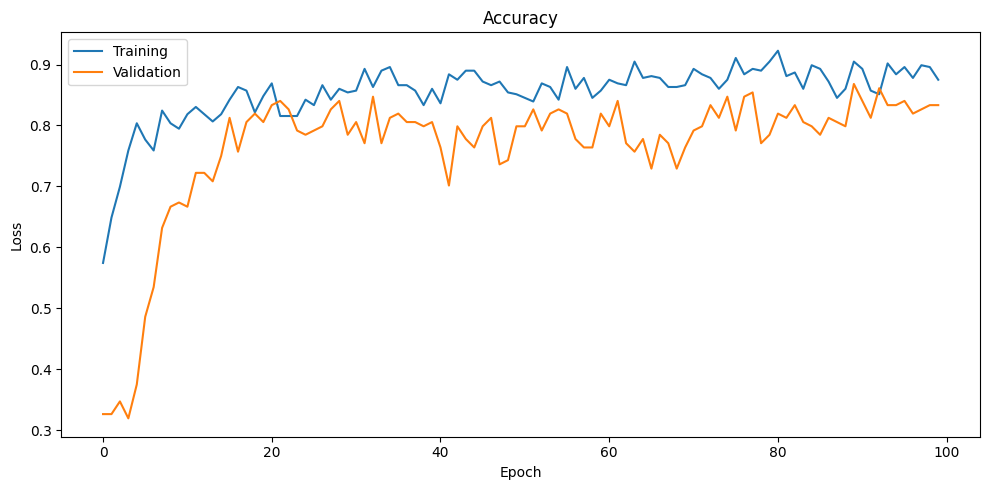

In [58]:
def display_training_curves(training, validation, title):
	plt.figure(figsize=(10, 5))
	
	# Plot loss
	plt.plot(training)
	plt.plot(validation)
	plt.title(title)
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.legend(['Training', 'Validation'])
	
	plt.tight_layout()
	plt.show()

display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss')
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

## 4. Model Evaluation

## Evaluation

In [59]:
model.load_weights('best_model_new.weights.h5')
_, accuracy = model.evaluate(test_dataset)
print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.9076 - loss: 0.3494
Validation accuracy: 87.5%


## Kfold validation

In [ ]:
# I have no idea how to do this